Небольшое условие: люди стали больше понимать как им вести себя во время эпидемии после начала мая; из-за чего эта модель обучалась на данных майских и более новых.

В основу этой модели было положено предположение, что человек, если он не болеет и работает, то появляется на людях примерно одинаковое количество времени (скажем в неделю). Но есть еще он может появиться на людях во время досуга и хотелось бы взять какой-то коэфициент желания выйти на улицу, но такими данными я не располагаю. Поэтому я решил предположить, что этот коэфициент может зависеть от погоды (тепло и ясно - гулять, прохладно и пасмурно - остаемся дома). И данная модель пытается предсказать распространенность covid по погоде.

In [12]:
# код, с помошбю которого обробатывали данные и обучали нейронную сеть находится в main.py
# в этом файле нам полезна часть функций из main.py
from main import *
import matplotlib.pyplot as plt
from dateutil.parser import parse as parse_date
import os

In [9]:
## Подготавливаем часть вспомогательных функций 

# Достаем из файлов фичи, на которых обучалась нейронная сеть и цели к которой стремится эта сеть
def get_train_data(location):
    stat = DataKeeper.get_covid_stat(location)
    wheather_data = DataKeeper.get_whether(location)

    features = to_wheather_features(wheather_data)
    gamma = to_gamma(stat, delta)
    return namedtuple("TrainData", "features,gamma")(features=features,gamma=gamma)

# Обрезаем часть данных - подводим данные к выбранной дате
def from_date(iterable, date):
    from dateutil.parser import parse as parse_date
    
    if isinstance(date, str):
        date = parse_date(date)
    result = Values(date)
    result.data = [val for valdate, val in iterable.items() if valdate >= date]
    return result

# конвертируем с помощью обученной модели данные
def features_to_gamma(model, features):
    result = Values(features.start_date)
    result.data = [model(torch.tensor(x))[0] for x in features.data]
    return result

# Возвращаем первые n элементов
def take(iterable, n):
    return [val for val, _ in zip(iterable, range(n))]

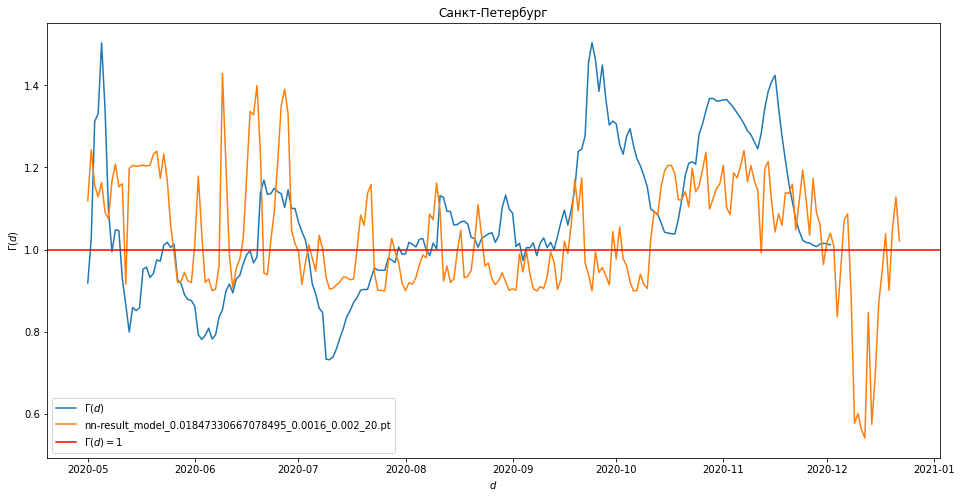

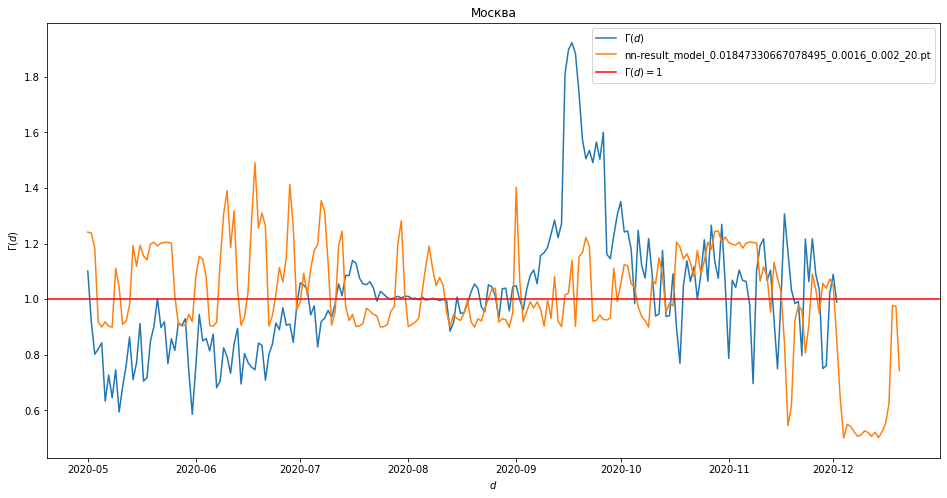

In [11]:
show_from_day = parse_date("2020-05-01")


# Строим для нескольких локаций реальные данные и те, что строит нейронная модель
for location in ["Санкт-Петербург", "Москва"]:
    plt.figure(figsize = (16, 8))
    plt.title(location)

    localdata = get_train_data(location)
    gamma = from_date(localdata.gamma, show_from_day)
    features = from_date(localdata.features, show_from_day)

    plt.plot(take(generate_dates_from(gamma.start_date), len(gamma)), gamma.data, label="$\Gamma(d)$")

    for path in os.listdir(get_full_path("../not_bad")):
        if path.endswith(".pt"):
            model = Net(3)
            model.load_state_dict(torch.load(get_full_path("../not_bad")+f"/{path}"))
            model.eval()

            nn_gamma = features_to_gamma(model, features)
            plt.plot(take(generate_dates_from(nn_gamma.start_date), len(nn_gamma)), nn_gamma.data, label="nn-"+path)

    plt.axhline(1, color='red', label = '$\Gamma(d) = 1$')
    plt.legend(loc= 'best')
    plt.xlabel('$d$')
    plt.ylabel('$\Gamma(d)$')
    plt.show()

Выводы: Так как нейронная сеть обучалась на данных СПб, то для этой локации она показывает лучшие результаты. Но тем не менее нельзя не упомянуть проблему нехватки данных для обучения и нужно больше новых идей для построения моделей.
